# Circularly polarized patch antenna with parasitic strips

In many applications, such as mobile communications, size, weight, and cost are the primary constraints that drive the design of antennas. In particular, cell phone antennas are required to be economical, low-profile, and easy to manufacture. Patch antennas are attractive devices for these applications, since they can be manufactured directly on printed-circuit boards, which makes their inclusion in cell phones especially convenient. In addition, the shape of a patch antenna can be chosen to imbue it with a variety of different characteristics, e.g., polarization, radiation pattern, and bandwidth.

<img src="img/circularly_polarized_patch_antenna.png" width="400" alt="Rendering of a circularly polarized patch antenna">

This notebook reproduces the results from [Wu et al.](https://ieeexplore.ieee.org/document/6963272). In [1], the authors propose a circularly polarized antenna with parasitic strips that has a lower profile and an improved circularly polarized bandwidth when compared to existing designs. This notebook also serves to introduce many key components of Tidy3D that are used in antenna simulations: 

* [DirectivityMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.DirectivityMonitor.html): The directivity monitor records and stores electromagnetic field data, which it uses to calculate far-field quantities such as radiation intensity and directivity.
* [CoaxialLumpedPort](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.smatrix.CoaxialLumpedPort.html): These ports are used to model a coaxial-type excitation, which includes a current source and load impedance.
* [TerminalComponentModeler](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.smatrix.TerminalComponentModeler.html): This tool, in the `smatrix` plugin, enables the calculation of scattering parameters and also the incident and reflected powers at each port, which is needed for calculating the antenna gain. The `TerminalComponentModeler` may be used to calculate many parameters of interest in antenna design. These antenna parameters are returned as a [AntennaMetricsData](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.AntennaMetricsData.html), which is calculated in a post-processing step after all simulations are completed.
* [LobeMeasurer](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.microwave.LobeMeasurer.html): This helper class finds the lobes in a radiation pattern and calculates lobe measures, such as the half power beamwidth.
  
Since this notebook uses many features, you may find the following notebooks helpful for understanding each feature separately.

* [Directivity and S-parameter Computation of Patch Antenna Notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/AntennaCharacteristics/)
* [Layer Refinement Notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/LayerRefinement/)
* [Coupled Line Bandpass Filter Notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/CoupledLineBandpassFilter/)

In [1]:
# standard python imports
import matplotlib.pyplot as plt
import numpy as np

# tidy3d imports
import tidy3d as td

# Import a few plugins which contain some of the tools we will use in this tutorial
import tidy3d.plugins.smatrix as smatrix
from tidy3d.plugins.dispersion import FastDispersionFitter
from tidy3d.plugins.microwave import LobeMeasurer

td.config.logging_level = "ERROR"

## Simulation Parameter Setup

We begin by setting the frequency range of interest (2.2 GHz to 3 GHz), which will be used to set up the source and monitors in the simulation. Next, we define geometric parameters from [1] that describe the shape and placement of the various components used in the antenna design. To compute $S_{11}$ of the antenna, we will use the [TerminalComponentModeler](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.smatrix.TerminalComponentModeler.html#tidy3d.plugins.smatrix.TerminalComponentModeler), which requires setting up a port excitation. The antenna in [1] is backed by a ground plane and excited by a feeding pin. In order to emulate a 50 $\Omega$ coaxial cable connected to the feeding pin, we introduce a 1.5 mm radius hole in the ground plane where we will place a `CoaxialLumpedPort`.


We model all conductors from [1] as perfect electric conductors (PECs). In [1], the substrate is modeled with a relative permittivity of 2.55 and frequency-independent loss tangent of 0.002. To ensure causality, in Tidy3D the loss tangent must be modeled using a dispersive material with pole-residue pairs. Fortunately, we can use the [constant_loss_tangent_model](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.dispersion.FastDispersionFitter.html#tidy3d.plugins.dispersion.FastDispersionFitter.constant_loss_tangent_model) to easily generate such a model.

In [2]:
# Frequency range of interest is 2.2 to 3 GHz
freq_start = 2.2e9
freq_stop = 3e9
# Center frequency of 2.6 GHz
freq0 = (freq_start + freq_stop) / 2
fwidth = freq_stop - freq_start
# Frequency sample points for monitors and post-processing
freqs = np.linspace(freq_start, freq_stop, 51)
# Center wavelength
wavelength0 = td.C_0 / freq0
# Longest wavelength
wavelength_start = td.C_0 / freq_start
# Run time of FDTD simulation
run_time = 10 / fwidth
# Tidy3D uses microns by default
mm = 1e3

# Parameters from [1]
G = 130 * mm  # Length and width of ground sheet
L = 73 * mm  # Length and width of substrate
L1 = 39 * mm  # Length and width of center patch
a = 21 * mm  # Width of corner cutout of center patch
fx = 15 * mm  # X position of feed pin
gx = 2 * mm  # Horizontal gap distance between center patch and parasitic patches
gy = 8 * mm  # Vertical gap distance between substrate boundary and parasitic patches
Ls = 36 * mm  # Length of parasitic patches
Ws = 15 * mm  # Width of parasitic patches
r1 = 2 * mm  # Ground pin pad size
r2 = 1.7 * mm  # Feed pin pad size
t = 1 * mm  # Substrate thickness
H = 14 * mm  # Distance between ground and substrate
rfeed = 0.65 * mm

# Custom parameters chosen for this simulation, not specified in [1]
# Chosen thickness of metal conductors other than the ground sheet (20 microns)
patch_thickness = 0.02 * mm
ground_thickness = 0.16 * mm
# Using an outer radius of 1.5 mm gives about 50 Ohms
# for the impedance of air filled coax that connects to the feeding pin.
coax_radius = 1.5 * mm

# Total structure height
structure_height = t + H + ground_thickness + patch_thickness
structure_center = 0.5 * (t + patch_thickness - H - ground_thickness)

# Define key vertical locations within the simulation domain.
top_substrate = t
bottom_substrate = 0
middle_ground = -H - ground_thickness / 2
port_location = -H - ground_thickness  # Port is located at the bottom of the ground.
# Calculate the diameter of the coaxial port based on the radius.
port_diameter = 2 * coax_radius

# PML buffer size added around structures
PML_buffer = wavelength_start / 2
# Simulation domain definition with sufficient padding around the structure for PMLs
sim_size = (G + 2 * PML_buffer, G + 2 * PML_buffer, structure_height + 2 * PML_buffer)
sim_center = [0, 0, structure_center]

# Define media in the simulation
epsr_sub = 2.55
air = td.Medium()
metal = td.PECMedium()
# Use FastDispersionFitter to create a material with an approximately correct loss tangent for the frequency range.
substrate_med = FastDispersionFitter.constant_loss_tangent_model(
    epsr_sub, 0.002, (freq_start, freq_stop)
)

Output()

## Create Structures

Next, we use the defined parameters to create all of the structures in the Tidy3D simulation and plot the created structure.

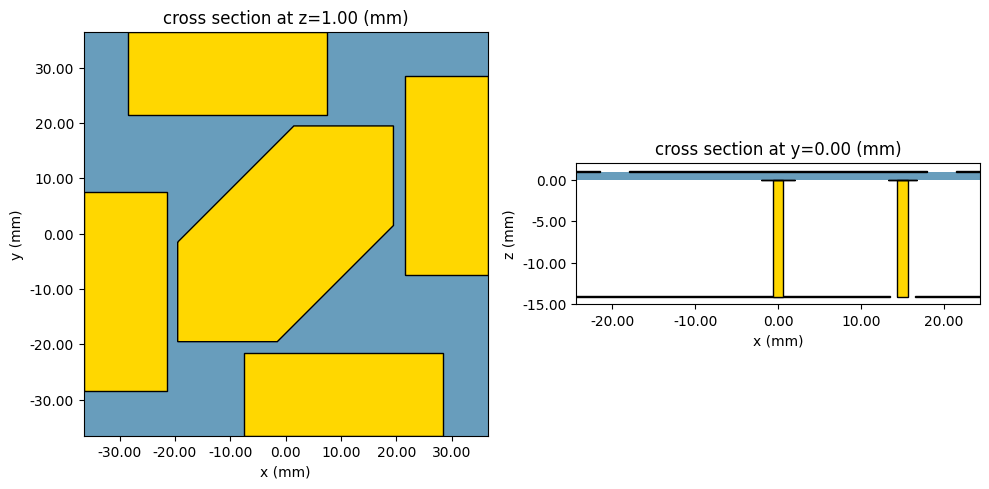

In [3]:
def make_structures(differential_feed: bool = False):
    """Makes all of the Tidy3D structures that represent the antenna in [1]. As in [1], we can choose to model the antenna
    with a differential feed, where a second feeding pin is added to the structure.
    """
    # Make structures for the simulation for either the proposed or differential feeds in [1].
    # Dielectric substrate that extends from the shorting and feeding pins to the patches
    substrate = td.Structure(
        geometry=td.Box(
            center=[0, 0, t / 2],
            size=[L, L, t],
        ),
        medium=substrate_med,
    )
    # A ground plane is connected to the bottom of the pins, where a small air gap is introduced for exciting the
    # feeding pin
    ground_box = td.Box(center=[0, 0, -H - ground_thickness / 2], size=[G, G, ground_thickness])
    # A cylindrical hole is created in the ground plane to allow for the coaxial cable connection at the feeding pin.
    feed_gap = td.Cylinder(
        center=(fx, 0, -H - ground_thickness / 2),
        radius=coax_radius,
        length=ground_thickness,
        axis=2,
    )

    if differential_feed:
        left_feed_gap = td.Cylinder(
            center=(-fx, 0, -H - ground_thickness / 2),
            radius=coax_radius,
            length=ground_thickness,
            axis=2,
        )
        feed_gap = td.GeometryGroup(geometries=(feed_gap, left_feed_gap))

    # The air gap is removed from the ground box
    ground_with_holes = td.ClipOperation(
        operation="difference", geometry_a=ground_box, geometry_b=feed_gap
    )
    # The final ground plane structure is created
    ground = td.Structure(
        geometry=ground_with_holes,
        medium=metal,
    )
    # Define the vertices that outline the shape of the central patch.
    main_vertices = np.array(
        [
            (-L1 / 2, -L1 / 2),
            (L1 / 2 - a, -L1 / 2),
            (L1 / 2, -L1 / 2 + a),
            (L1 / 2, L1 / 2),
            (-L1 / 2 + a, L1 / 2),
            (-L1 / 2, L1 / 2 - a),
        ]
    )
    # Using the vertices, a polyslab structure is created with the previously defined patch_thickness.
    main_patch = td.Structure(
        geometry=td.PolySlab(
            vertices=main_vertices.tolist(),
            slab_bounds=(t, t + patch_thickness),
            axis=2,
        ),
        medium=metal,
    )
    # The remaining parasitic strips are sequentially-rotated rectangles around the central patch.
    patch_L = td.Box(
        center=(-L / 2 + Ws / 2, -L / 2 + gy + Ls / 2, t + patch_thickness / 2),
        size=(Ws, Ls, patch_thickness),
    )
    patch_R = td.Box(
        center=(L / 2 - Ws / 2, L / 2 - gy - Ls / 2, t + patch_thickness / 2),
        size=(Ws, Ls, patch_thickness),
    )
    patch_B = td.Box(
        center=(L / 2 - Ls / 2 - gy, -L / 2 + Ws / 2, t + patch_thickness / 2),
        size=(Ls, Ws, patch_thickness),
    )
    patch_T = td.Box(
        center=(-L / 2 + Ls / 2 + gy, L / 2 - Ws / 2, t + patch_thickness / 2),
        size=(Ls, Ws, patch_thickness),
    )
    # Conductive pads for the feeding and shorting pins, placed at the bottom of the substrate.
    feed_disc = td.Cylinder(
        center=(fx, 0, -patch_thickness / 2), radius=r2, length=patch_thickness, axis=2
    )
    if differential_feed:
        shorted_disc = td.Cylinder(
            center=(-fx, 0, -patch_thickness / 2), radius=r2, length=patch_thickness, axis=2
        )
    else:
        shorted_disc = td.Cylinder(
            center=(0, 0, -patch_thickness / 2), radius=r1, length=patch_thickness, axis=2
        )
    # All patch structures are collected into a list and assigned the same material
    patch_geoms = [patch_L, patch_R, patch_B, patch_T, feed_disc, shorted_disc]
    patch_structures = [td.Structure(geometry=patch, medium=metal) for patch in patch_geoms]

    # Next, the shorting and feeding pins are added to the simulation as cylinders.
    if differential_feed:
        # Short pin represents the other feed when using the differential feed configuration.
        short_pin = td.Structure(
            geometry=td.Cylinder(
                center=(-fx, 0, -H / 2 - ground_thickness / 2),
                radius=rfeed,
                length=H + ground_thickness,
                axis=2,
            ),
            medium=metal,
        )
    else:
        short_pin = td.Structure(
            geometry=td.Cylinder(
                center=(0, 0, -H / 2 - ground_thickness / 2),
                radius=rfeed,
                length=H + ground_thickness,
                axis=2,
            ),
            medium=metal,
        )
    feed_pin = td.Structure(
        geometry=td.Cylinder(
            center=(fx, 0, -H / 2 - ground_thickness / 2),
            radius=rfeed,
            length=H + ground_thickness,
            axis=2,
        ),
        medium=metal,
    )
    # Create a list of all structures in the simulation.
    return [
        substrate,
        ground,
        feed_pin,
        short_pin,
        main_patch,
    ] + patch_structures


structures_list = make_structures(differential_feed=False)
# Setting up the scene for visualization, with all structures included
# and units set to millimeters for the plot.
scene = td.Scene(structures=structures_list, plot_length_units="mm")
fig, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
sub_ax = axs[0]
scene.plot(z=t, ax=sub_ax)
sub_ax.set_xlim(-L / 2, L / 2)
sub_ax.set_ylim(-L / 2, L / 2)
sub_ax = axs[1]
scene.plot(y=0, ax=sub_ax)
sub_ax.set_xlim(-L / 3, L / 3)
sub_ax.set_ylim(-H - t, 2 * t)
plt.show()

## Mesh Overrides and Layer Refinement Specification

In this antenna design, there are many subwavelength features that may not be captured accurately using the default grid generated by Tidy3D, even when using the [PECConformal](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PECConformal.html#tidy3d.PECConformal) subpixel feature. For instance, both the metal patch thickness and the gap between the central patch and parasitic strips are subwavelength. In addition, the radius of the shorting pin and feeding pin are also relatively small. To enhance the accuracy of this simulation, we will use two components: [MeshOverrideStructures](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.MeshOverrideStructure.html#tidy3d.MeshOverrideStructure) and [LayerRefinementSpec](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.LayerRefinementSpec.html).

The `MeshOverrideStructure`s are used to refine the grid near the locations of the shorting and feeding pins. We use `MeshOverrideStructure`s to ensure that there will be about four grid cells in the gap between the feeding pin and ground plane, where the excitation will be placed. Finally, another similar `MeshOverrideStructure` is added near the shorting pin to resolve the cylinder's surface accurately.

We also make use of the `LayerRefinementSpec` feature, which automatically creates refined mesh in each layer defined by the user. We choose to refine the mesh around metallic objects on the top and bottom of the substrate. In addition, we add a `LayerRefinementSpec` corresponding to the ground plane.

In [4]:
def make_grid_spec(use_differential_feed: bool = False):
    # Make a GridSpec for the simulation for either the proposed or differential feeds in [1].
    # Set the size of grid cells to be used for the portion of the structure containing all patches.
    # Choose the cell size in the xy-plane to ensure there are 4 cells across the gap between the main patch and parasitic strips.
    dl_plane = gx / 4
    # Vertical cell size around printed components
    dz_metal = 100

    # Provide a larger cell size (dl value) for regions or dimensions that do not require fine resolution.
    dl_background = 10 * mm
    # Set the cell size at the port to fit approximately `port_cells` between the feed pin and ground
    port_cells = 4
    dl_pins = (coax_radius - rfeed) / port_cells
    # Add MeshOverrideStructures around both pins, which will capture the curved geometry of the cylinders more accurately.
    # These MeshOverrideStructures also improve the accuracy of the fields in the air gap, where the port excitation will be placed.
    short_x_center = 0
    if use_differential_feed:
        short_x_center = -fx
    mesh_overrides = [
        td.MeshOverrideStructure(
            geometry=td.Box(
                center=[fx, 0, middle_ground],
                size=[port_diameter, port_diameter, ground_thickness],
            ),
            dl=[dl_pins, dl_pins, dl_background],
        ),
        td.MeshOverrideStructure(
            geometry=td.Box(
                center=[short_x_center, 0, middle_ground],
                size=[port_diameter, port_diameter, ground_thickness],
            ),
            dl=[dl_pins, dl_pins, dl_background],
        ),
    ]

    top_substrate_spec = td.LayerRefinementSpec.from_layer_bounds(
        bounds=(top_substrate, top_substrate + patch_thickness),
        axis=2,
        bounds_snapping="lower",
        bounds_refinement=td.GridRefinement(dl=dz_metal),
        corner_refinement=td.GridRefinement(dl=dl_plane / 2),
    )
    bottom_substrate_spec = td.LayerRefinementSpec.from_layer_bounds(
        bounds=(bottom_substrate - patch_thickness, bottom_substrate),
        axis=2,
        bounds_snapping="upper",
        bounds_refinement=td.GridRefinement(dl=dz_metal),
    )
    ground_spec = td.LayerRefinementSpec.from_layer_bounds(
        min_steps_along_axis=1,
        bounds=(-H - ground_thickness, -H),
        axis=2,
        bounds_snapping="bounds",
    )
    return td.GridSpec.auto(
        min_steps_per_wvl=20,
        wavelength=td.C_0 / freq_stop,
        layer_refinement_specs=[top_substrate_spec, bottom_substrate_spec, ground_spec],
        override_structures=mesh_overrides,
    )


grid_spec = make_grid_spec(use_differential_feed=False)

Now, we plot the created geometry along with the FDTD grid to see how the `MeshOverrideStructure`s and `LayerRefinementSpec`s have affected the grid. In the first figure, you can clearly see the mesh refinement created by the `MeshOverrideStructure`s around the shorting and feeding pins. The figure on the right shows a close-up of the gap region between the central patch and a parasitic strip. The purple markers indicate the locations of corners where the mesh grid has been snapped and refined. The subsequent plot illustrates the refined grid near the port location, clearly showing the desired four grid cells between the inner and outer conductors.

{'Nx': 274, 'Ny': 255, 'Nz': 103, 'grid_points': 7196610, 'min_grid_size': 75.0, 'max_grid_size': 4996.540966666886, 'computational_complexity': 95954.8}


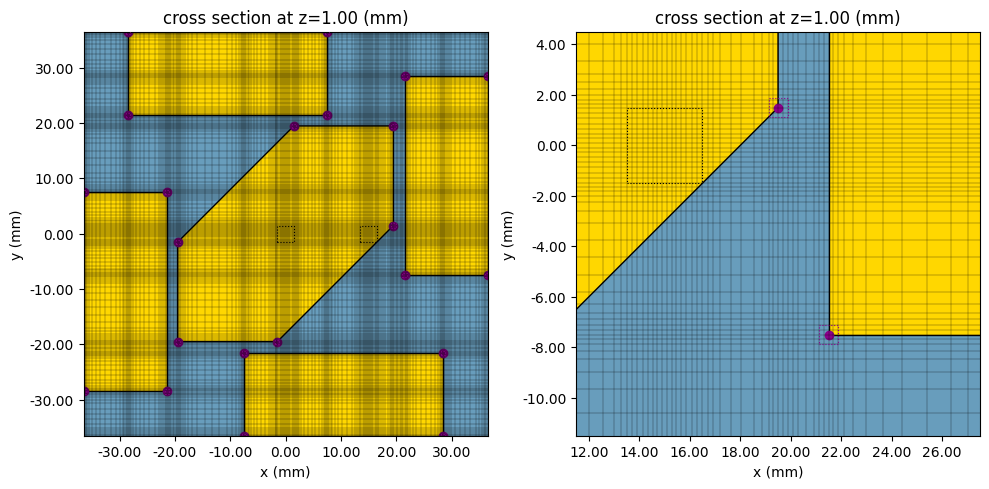

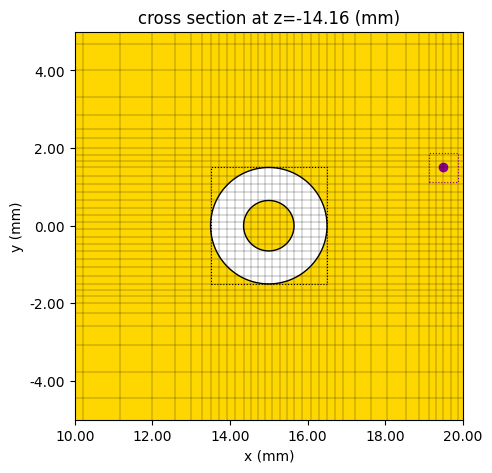

In [5]:
# Create simulation object, so that we can view the created grid superimposed with simulation structures.
sim = td.Simulation(
    center=sim_center,
    size=sim_size,
    grid_spec=grid_spec,
    structures=structures_list,
    run_time=run_time,
    plot_length_units="mm",
)

# Display information about the simulation grid, including the number of cells along each axis and the smallest cell size,
# which are important for simulation accuracy.
print(sim.grid_info)

# Create two plots: one showing the overall grid and simulation setup, and another zoomed in near the gap and feed pin location.
fig, axs = plt.subplots(1, 2, figsize=(10, 10), tight_layout=True)
sub_ax = axs[0]
sim.plot(z=t, ax=sub_ax, monitor_alpha=0)
sim.plot_grid(z=t, ax=sub_ax)
sub_ax.set_xlim(-L / 2, L / 2)
sub_ax.set_ylim(-L / 2, L / 2)
sub_ax = axs[1]
sim.plot(z=t, ax=sub_ax, monitor_alpha=0)
sim.plot_grid(z=t, ax=sub_ax)
sub_ax.set_xlim(L1 / 2 - 4 * gx, L1 / 2 + 4 * gx)
sub_ax.set_ylim(L / 2 - gy - Ls - 2 * gx, L / 2 - gy - Ls + 6 * gx)
plt.show()

# Create a detailed plot at the port location to verify the mesh refinement in this critical region.
fig, ax = plt.subplots(figsize=(5, 5), tight_layout=True)
sim.plot(z=port_location, ax=ax)
sim.plot_grid(z=port_location, ax=ax)
ax.set_xlim(fx - 5 * mm, fx + 5 * mm)
ax.set_ylim(-5 * mm, 5 * mm)
plt.show()

## Simulation Monitors

In this notebook, we wish to compute a variety of antenna parameters. We will first create plots of the normalized radiation pattern at 2.6 GHz for right-handed and left-handed circular polarizations. We will also reproduce a few plots from [1] that are functions of frequency, i.e., the axial ratio and the antenna gain along the *z* axis. In order to create these plots efficiently, we use one `DirectivityMonitor` that records the far-field pattern over a range of directions at a fixed frequency. We use a separate `DirectivityMonitor` to capture the field over a range of frequencies at a specific observation point, denoted by spherical coordinates $(\theta=0, \phi=0)$.

In [6]:
# Place the far field monitors just inside simulation boundaries
farfield_size = (sim_size[0] * 0.9, sim_size[1] * 0.9, sim_size[2] * 0.9)
# Radial distance away from the origin at which to project fields.
r_proj = 50 * wavelength0
# Theta and Phi angles at which to observe fields
theta_proj = np.linspace(0, 2 * np.pi, 200, endpoint=False)
phi_proj = np.linspace(0, np.pi / 2, 2)

# First, create a FieldProjectionAngleMonitor that will be used to plot the radiation pattern in the xz and yz planes
mon_rad_spatial = td.DirectivityMonitor(
    center=sim_center,
    size=farfield_size,
    # the size and center of any far field monitor should indicate where the *near* fields are recorded
    freqs=[freq0],
    name="rad_spatial",
    phi=list(phi_proj),
    theta=list(theta_proj),
    proj_distance=r_proj,
    far_field_approx=True,  # Compute the radiated fields in the far field.
)

# Next, create a FieldProjectionAngleMonitor that will be used to compute radiated fields normal to the antenna vs the frequency.
mon_rad_freqency = td.DirectivityMonitor(
    center=sim_center,
    size=farfield_size,
    freqs=freqs,  # Record radiated fields for different frequencies.
    name="rad_frequency",
    phi=[0],  # Record radiated fields normal to the antenna
    theta=[0],
    proj_distance=r_proj,
    far_field_approx=True,  # Compute the radiated fields in the far field.
)

## Set up the `TerminalComponentModeler`

The last step before launching the simulation is to set up the `TerminalComponentModeler`, which will simplify the calculation of $S_{11}$. As previously mentioned, we use a `CoaxialLumpedPort` with a reference impedance of $50 \Omega$ as the source. The `CoaxialLumpedPort` will model a radially directed uniform current source and an annular resistive load between the feed pin and ground plane. Scattering parameters calculated with this definition of the `CoaxialLumpedPort` should match experimental results where a coaxial cable is used with characteristic impedance of $50 \Omega$.

In [7]:
# Use a CoaxialLumpedPort to excite the feed pin. The CoaxialLumpedPort models a radially symmetric current
# flowing from the feed pin to the ground plane through a resistive element.
coax_center = [fx, 0, port_location]
coax_port = smatrix.CoaxialLumpedPort(
    center=coax_center,
    outer_diameter=port_diameter,
    # Defines the boundary for the outer conductor, which in this case is the ground plane.
    inner_diameter=2
    * rfeed,  # Defines the boundary for the inner conductor, corresponding to the feed pin diameter.
    normal_axis=2,
    direction="+",  # Indicates that the current will flow in the positive direction along the feed pin.
    name="coax_port",
    num_grid_cells=None,  # The port grid refinement is handled manually with MeshOverrideStructures, hence 'None'.
)
modeler = smatrix.TerminalComponentModeler(
    simulation=sim,
    ports=[coax_port],
    radiation_monitors=(mon_rad_spatial, mon_rad_freqency),
    freqs=freqs,
    remove_dc_component=True,
    verbose=True,
)

Next, we run the simulation that computes the scattering matrix. After the simulation is complete, we retrieve the `BatchData` and `SimulationData`, which contain the results from the far-field monitors.

In [8]:
# Run the TerminalComponentModeler and populate the scattering matrix of this single CoaxialLumpedPort network.
s_matrix = modeler.run()

Output()

15:55:17 EST Started working on Batch containing 1 tasks.

15:55:18 EST Maximum FlexCredit cost: 0.245 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

15:56:17 EST Batch complete.

Output()

## Postprocessing
### Polar plots of normalized radiation patterns
We will use the simulation results to reproduce Fig. 10 (b) from [1]. First, we retrieve the radiation intensities using the helper method `get_antenna_metrics_data`, which returns a `AntennaMetricsData` object. The radiation intensities are obtained in the circular polarization basis, which is decomposed into right-handed circular polarization (RHCP) and left-handed circular polarization (LHCP) components. Then, we normalize by the peak total radiation intensity.

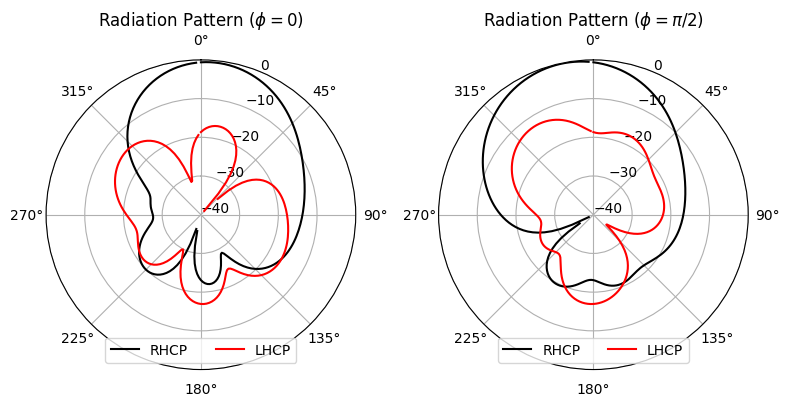

In [9]:
antenna_parameters_spatial = modeler.get_antenna_metrics_data(monitor_name="rad_spatial")
partial_U = antenna_parameters_spatial.partial_radiation_intensity(pol_basis="circular").sel(
    f=freq0
)
peakU = np.max(antenna_parameters_spatial.radiation_intensity)
normalized_partial_U = partial_U / peakU

# Select fields along theta for phi = 0 and phi = pi/2
Urad_RH_Phi_0 = normalized_partial_U.Uright.sel(phi=0).squeeze().values
Urad_LH_Phi_0 = normalized_partial_U.Uleft.sel(phi=0).squeeze().values
Urad_RH_Phi_90 = normalized_partial_U.Uright.sel(phi=np.pi / 2).squeeze().values
Urad_LH_Phi_90 = normalized_partial_U.Uleft.sel(phi=np.pi / 2).squeeze().values

# Plot the normalized radiation pattern similar to [1].
fig, ax = plt.subplots(1, 2, subplot_kw={"projection": "polar"}, figsize=(8, 4))
sub_ax = ax[0]
sub_ax.set_theta_direction(-1)
sub_ax.set_theta_offset(np.pi / 2.0)
sub_ax.plot(theta_proj, 10 * np.log10(Urad_RH_Phi_0), "-k", label="RHCP")
sub_ax.plot(theta_proj, 10 * np.log10(Urad_LH_Phi_0), "-r", label="LHCP")
sub_ax.set_rlim(-40, 0)
sub_ax.set_rticks([-40, -30, -20, -10, 0])
sub_ax.set_title(r"Radiation Pattern ($\phi = 0$)")
sub_ax.legend(loc="lower center", ncols=2)

sub_ax = ax[1]
sub_ax.set_theta_direction(-1)
sub_ax.set_theta_offset(np.pi / 2.0)
sub_ax.plot(theta_proj, 10 * np.log10(Urad_RH_Phi_90), "-k", label="RHCP")
sub_ax.plot(theta_proj, 10 * np.log10(Urad_LH_Phi_90), "-r", label="LHCP")
sub_ax.set_rlim(-40, 0)
sub_ax.set_rticks([-40, -30, -20, -10, 0])
sub_ax.set_title(r"Radiation Pattern ($\phi = \pi/2$)")
sub_ax.legend(loc="lower center", ncols=2)
fig.tight_layout()
plt.show()

### Finding antenna lobes with the `LobeMeasurer`

Given a 1D array of values representing the radiation pattern, we can use the `LobeMeasurer` tool to find the direction of the main antenna lobes.

In [10]:
xz_plane_lobe_measurer = LobeMeasurer(angle=theta_proj, radiation_pattern=Urad_RH_Phi_0)
main_lobe_phi_0 = xz_plane_lobe_measurer.main_lobe["direction"] * 180 / np.pi

yz_plane_lobe_measurer = LobeMeasurer(angle=theta_proj, radiation_pattern=Urad_RH_Phi_90)
main_lobe_phi_90 = yz_plane_lobe_measurer.main_lobe["direction"] * 180 / np.pi - 360

print(f"The main lobe direction in the xz-plane is {main_lobe_phi_0:.2f} degrees.")
print(f"The main lobe direction in the yz-plane is {main_lobe_phi_90:.2f} degrees.")

The main lobe direction in the xz-plane is 5.40 degrees.
The main lobe direction in the yz-plane is -10.80 degrees.


The beam directions are close to the values reported in [1], which are 5 degrees in the *xz* plane and -10 degrees in the *yz* plane.

### Plot of $S_{11}$
Next, we reproduce Fig. 9 (a) from [1] using the scattering parameter computed by the `TerminalComponentModeler`.

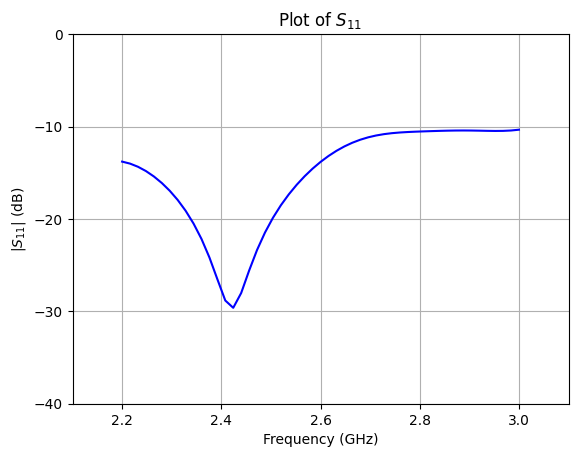

In [11]:
# Plot the reflection coefficient using the scattering parameter computed by the TerminalComponentModeler
freq = s_matrix.f / 1e9
s_11 = 20 * np.log10(np.abs(s_matrix.isel(port_out=0, port_in=0).values.flatten()))
plt.plot(freq, s_11, "-b")
plt.xlabel("Frequency (GHz)")
plt.ylabel(r"$|S_{11}|$ (dB)")
plt.title(r"Plot of $S_{11}$")
# Make the plot identical to [1].
plt.xlim(2.1, 3.1)
plt.ylim(-40, 0)
plt.yticks([-40, -30, -20, -10, 0])
plt.grid(True)
plt.show()

### Compute and plot the axial ratio
Next, we use the simulation results to reproduce Fig. 9 (a) from [1].

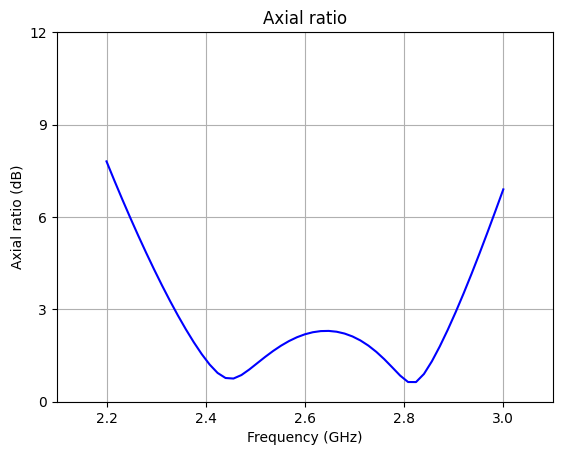

In [12]:
# Retrieve the field data from the "rad_frequency" monitor
antenna_parameters_freq = modeler.get_antenna_metrics_data(monitor_name="rad_frequency")
axial_ratio = antenna_parameters_freq.axial_ratio

freq = axial_ratio.f.values.squeeze() / 1e9
axial_ratio_dB = 20 * np.log10(np.abs(axial_ratio.values.squeeze()))
plt.plot(freq, axial_ratio_dB, "-b")
plt.xlabel("Frequency (GHz)")
plt.ylabel("Axial ratio (dB)")
plt.title("Axial ratio")
# Make the plot identical to [1].
plt.xlim(2.1, 3.1)
plt.ylim(0, 12)
plt.yticks([0, 3, 6, 9, 12])
plt.grid(True)
plt.show()

### Compute and plot the antenna gain for RHCP
We plot the antenna gain for the RHCP component. These results can be retrieved from `AntennaMetricsData` by specifying a "circular" polarization basis.
The gain is calculated by multiplying the directivity by the radiation efficiency of the antenna. The resulting plot will replicate Fig. 9 (b) from [1].

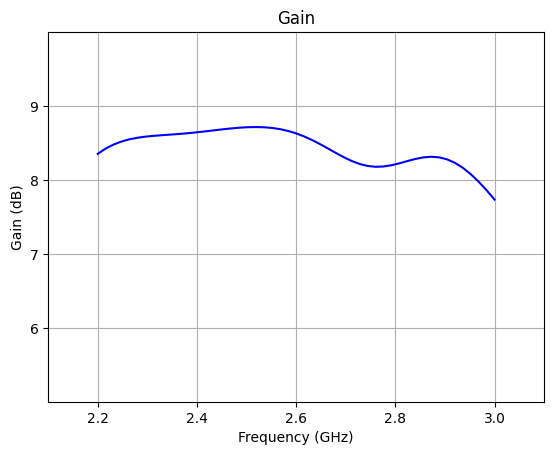

In [13]:
freq = antenna_parameters_freq.f.squeeze() / 1e9
gain = antenna_parameters_freq.partial_gain(pol_basis="circular").Gright.values.squeeze()
gain_dB = 10 * np.log10(gain)
plt.plot(freq, gain_dB, "-b")
plt.xlabel("Frequency (GHz)")
plt.ylabel("Gain (dB)")
plt.title("Gain")
plt.xlim(2.1, 3.1)
plt.ylim(5, 10)
plt.yticks([6, 7, 8, 9])
plt.grid(True)
plt.show()

## Setting Up and Simulating the Differential Feed Antenna Configuration

In [1], the proposed single-feed excitation is compared to a differential feed excitation, where the ground pin is removed and a second feed pin is added. We can reproduce the results in [1] by changing the Tidy3D simulation to reflect the new geometry, as well as adding an additional coaxial port to the `TerminalComponentModeler`.

The radiated fields due to the differential feed configuration can be calculated as a post-processsing step in the `TerminalComponentModeler`, which forms a superposition of the fields with user-defined port amplitudes. However, unlike the single feed case, we need to recompute the radiated power by integrating over a spherical surface. As a result, we need to ensure that the `DirectivityMonitor` samples the electromagnetic field over an entire sphere. In this section, we will use a single `DirectivityMonitor` that will sample both the spatial coordinates and all desired frequency values.

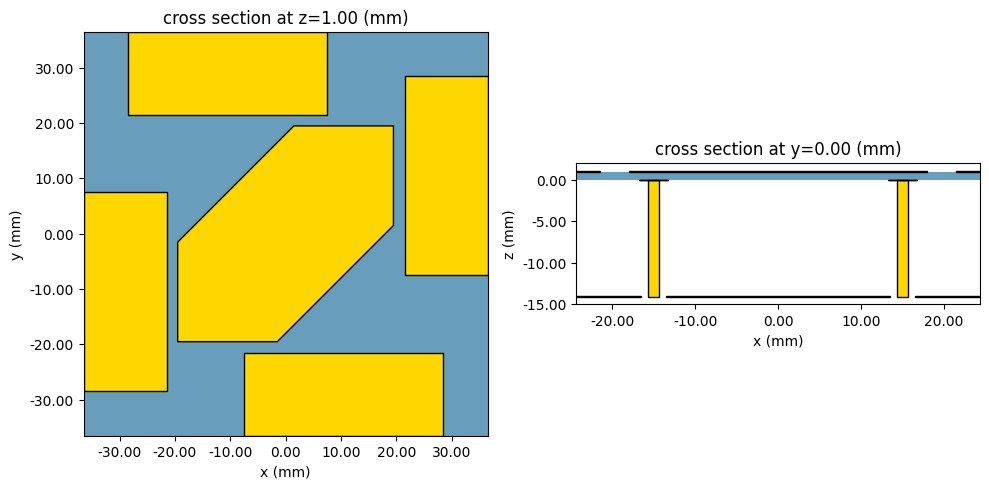

In [14]:
# Create simulation in the differential feed configuration
structures_list = make_structures(True)
grid_spec = make_grid_spec(True)

# Create a new monitor that samples entire spherical surface
theta_proj2 = np.linspace(0, np.pi, 101)
phi_proj2 = np.linspace(0, 2 * np.pi, 200)

# First, create a DirectivityMonitor that will be used to plot the radiation pattern in the xz and yz planes
mon_rad_spatial = td.DirectivityMonitor(
    center=sim_center,
    size=farfield_size,
    freqs=freqs,
    name="rad_spatial",
    phi=list(phi_proj2),
    theta=list(theta_proj2),
    proj_distance=r_proj,
    far_field_approx=True,  # Compute the radiated fields in the far field.
)
sim = sim.updated_copy(structures=structures_list, grid_spec=grid_spec)

# Setting up the scene for visualization, with all structures included
# and units set to millimeters for the plot.
scene = td.Scene(structures=structures_list, plot_length_units="mm")
fig, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
sub_ax = axs[0]
scene.plot(z=t, ax=sub_ax)
sub_ax.set_xlim(-L / 2, L / 2)
sub_ax.set_ylim(-L / 2, L / 2)
sub_ax = axs[1]
scene.plot(y=0, ax=sub_ax)
sub_ax.set_xlim(-L / 3, L / 3)
sub_ax.set_ylim(-H - t, 2 * t)
plt.show()

Then, we create a new `TerminalComponentModeler` with an additional port, the modified `Simulation`, and the modified radiation monitor.

In [15]:
diff_center = [-fx, 0, port_location]
diff_port = coax_port.updated_copy(center=diff_center, name="diff_port")

modeler_diff_feed = modeler.updated_copy(
    simulation=sim, ports=[coax_port, diff_port], radiation_monitors=[mon_rad_spatial]
)

In [16]:
# Run the TerminalComponentModeler and populate the scattering matrix of this single CoaxialLumpedPort network.
s_matrix = modeler_diff_feed.run()

Output()

15:56:23 EST Started working on Batch containing 2 tasks.

15:56:25 EST Maximum FlexCredit cost: 0.669 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

15:57:08 EST Batch complete.

Output()

### Comparison of the radiation patterns for the different feed configurations
We use the simulation results to partially reproduce Fig. 7 (b) from [1]. We retrieve the directivities using the helper method `get_antenna_metrics_data`, which returns an `AntennaMetricsData` object. We retrieve the partial directivity, which corresponds with the right-handed circular polarization (RHCP) component.

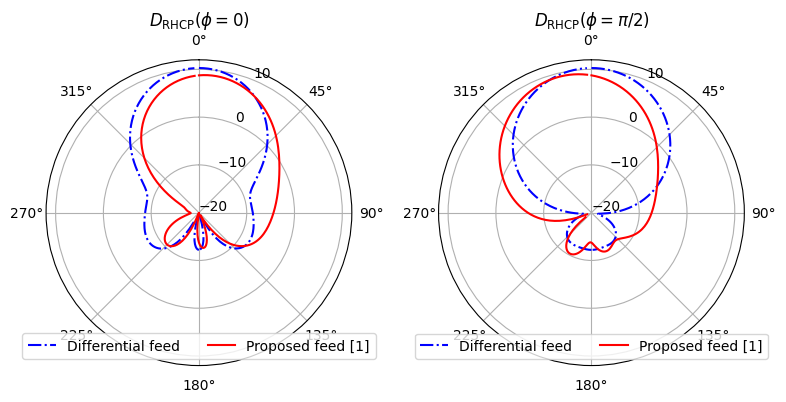

In [17]:
# Get the directivity from the original modeler using the proposed feed
D_right = antenna_parameters_spatial.partial_directivity(pol_basis="circular").Dright.sel(f=freq0)
# Select fields along theta for phi=0 and phi = pi/2
D_Phi_0 = D_right.sel(phi=0).squeeze().values
D_Phi_90 = D_right.sel(phi=np.pi / 2).squeeze().values

# Create a differential excitation by setting the amplitudes of the two ports to be equal in magnitude but opposite in phase.
port_amplitudes = {"coax_port": 1.0, "diff_port": -1.0}
antenna_parameters_shell = modeler_diff_feed.get_antenna_metrics_data(
    port_amplitudes, monitor_name="rad_spatial"
)
D_right_diff = antenna_parameters_shell.partial_directivity(pol_basis="circular").Dright.sel(
    f=freq0
)

# These helper functions are used to extract the fields along theta for phi=0 and phi=pi/2, so that theta is in the range [0, 2*pi).
D_Phi_0_diff = antenna_parameters_shell.get_phi_slice(D_right_diff, 0.0)
D_Phi_90_diff = antenna_parameters_shell.get_phi_slice(D_right_diff, np.pi / 2)
theta_plot = D_Phi_90_diff.theta.values
# Convert to numpy arrays for plotting
D_Phi_0_diff = D_Phi_0_diff.squeeze().values
D_Phi_90_diff = D_Phi_90_diff.squeeze().values

# Plot the partial directivities similar to [1].
fig, ax = plt.subplots(1, 2, subplot_kw={"projection": "polar"}, figsize=(8, 4))
sub_ax = ax[0]
sub_ax.set_theta_direction(-1)
sub_ax.set_theta_offset(np.pi / 2.0)
sub_ax.plot(theta_plot, 10 * np.log10(D_Phi_0_diff), "-.b", label="Differential feed")
sub_ax.plot(theta_proj, 10 * np.log10(D_Phi_0), "-r", label="Proposed feed [1]")
sub_ax.set_rlim(-20, 12)
sub_ax.set_rticks([-20, -10, 0, 10])
sub_ax.set_title(r"$D_{\rm RHCP}$($\phi = 0$)")
sub_ax.legend(loc="lower center", ncols=2)

sub_ax = ax[1]
sub_ax.set_theta_direction(-1)
sub_ax.set_theta_offset(np.pi / 2.0)
sub_ax.plot(theta_plot, 10 * np.log10(D_Phi_90_diff), "-.b", label="Differential feed")
sub_ax.plot(theta_proj, 10 * np.log10(D_Phi_90), "-r", label="Proposed feed [1]")
sub_ax.set_rlim(-20, 12)
sub_ax.set_rticks([-20, -10, 0, 10])
sub_ax.set_title(r"$D_{\rm RHCP}$($\phi = \pi/2$)")
sub_ax.legend(loc="lower center", ncols=2)
fig.tight_layout()
plt.show()

### Gain comparison for the different feed configurations
Next, we plot the gain of both feed types. Again, these results can be retrieved from the `AntennaMetricsData` object by specifying a "circular" polarization basis. The resulting plot will replicate Fig. 6 (b) from [1].

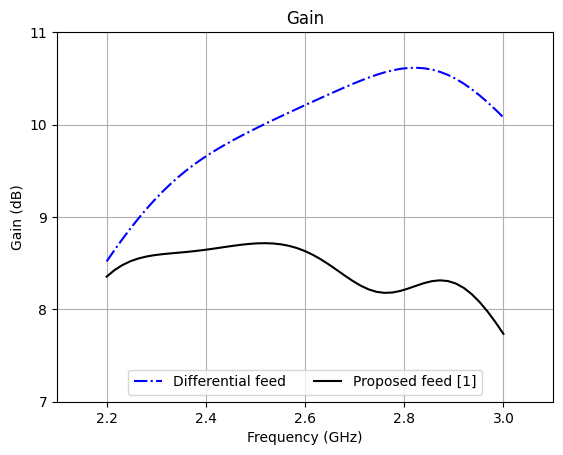

In [18]:
freq = antenna_parameters_shell.f.squeeze() / 1e9
gain_diff = (
    antenna_parameters_shell.partial_gain(pol_basis="circular")
    .Gright.sel(theta=0, phi=0)
    .values.squeeze()
)
gain_diff_dB = 10 * np.log10(gain_diff)
plt.plot(freq, gain_diff_dB, "-.b", label="Differential feed")
plt.plot(freq, gain_dB, "-k", label="Proposed feed [1]")
plt.xlabel("Frequency (GHz)")
plt.ylabel("Gain (dB)")
plt.title("Gain")
plt.xlim(2.1, 3.1)
plt.ylim(7, 11)
plt.yticks([7, 8, 9, 10, 11])
plt.legend(loc="lower center", ncols=2)
plt.grid(True)
plt.show()

## References

[1] J. Wu, Y. Yin, Z. Wang and R. Lian, "Broadband Circularly Polarized Patch Antenna With Parasitic Strips," in *IEEE Antennas and Wireless Propagation Letters*, vol.   14, pp. 559-562, 2015.

[2] C. A. Balanis, *Antenna Theory: Analysis and Design*. John Wiley & Sons, 2016.